# Exemplo de utilização do MOE

### dataset California Housing
### usando 2 autoencoder simples
### combinar o espaço latente dos modelos

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns


seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

cal_housing = fetch_california_housing()
X = cal_housing.data  
y = cal_housing.target  


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=seed)

X_train_tensor = torch.from_numpy(X_train)
X_test_tensor = torch.from_numpy(X_test)

batch_size = 64
train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Formato X_train:", X_train.shape, "Formato X_test:", X_test.shape)

Usando dispositivo: cpu
Formato X_train: (16512, 8) Formato X_test: (4128, 8)


## Definindo a estrutura de 2 autoencoder simples usando torch

In [ ]:

class Autoencoder1(nn.Module):
    def __init__(self, input_dim=8, latent_dim=2):
        super(Autoencoder1, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_rec = self.decoder(z)
        return x_rec, z

class Autoencoder2(nn.Module):
    def __init__(self, input_dim=8, latent_dim=2):
        super(Autoencoder2, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 40),
            nn.Tanh(),
            nn.Linear(40, 10),
            nn.Tanh(),
            nn.Linear(10, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 10),
            nn.Tanh(),
            nn.Linear(10, 40),
            nn.Tanh(),
            nn.Linear(40, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_rec = self.decoder(z)
        return x_rec, z

# Instanciar os modelos
autoencoder1 = Autoencoder1().to(device)
autoencoder2 = Autoencoder2().to(device)

## Realizando o treinamento do primeiro autoencoder 

In [ ]:

num_epochs_ae = 100  
lr = 1e-3

criterion = nn.MSELoss()
optimizer1 = optim.Adam(autoencoder1.parameters(), lr=lr)

train_losses_ae1 = []

for epoch in range(num_epochs_ae):
    autoencoder1.train()
    epoch_loss = 0
    for batch in train_loader:
        x_batch = batch[0].to(device)
        optimizer1.zero_grad()
        x_rec, _ = autoencoder1(x_batch)
        loss = criterion(x_rec, x_batch)
        loss.backward()
        optimizer1.step()
        epoch_loss += loss.item() * x_batch.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    train_losses_ae1.append(epoch_loss)
    
    if (epoch+1) % 20 == 0:
        print(f"[AE1] Epoch {epoch+1}/{num_epochs_ae}, Loss: {epoch_loss:.6f}")

[AE1] Epoch 20/100, Loss: 0.147355
[AE1] Epoch 40/100, Loss: 0.135614
[AE1] Epoch 60/100, Loss: 0.136652
[AE1] Epoch 80/100, Loss: 0.111810
[AE1] Epoch 100/100, Loss: 0.104084


## Métricas geradas do primeiro autoencoder



Autoencoder1 - Test MSE: 0.173474, MAE: 0.224720


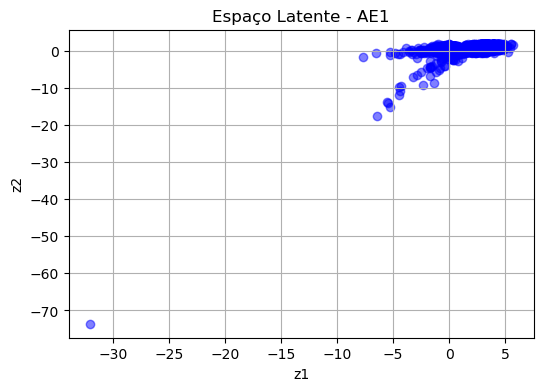

In [ ]:

autoencoder1.eval()
X_test_rec1 = []
latents1 = []

with torch.no_grad():
    for batch in test_loader:
        x_batch = batch[0].to(device)
        x_rec, z = autoencoder1(x_batch)
        X_test_rec1.append(x_rec.cpu().numpy())
        latents1.append(z.cpu().numpy())

X_test_rec1 = np.concatenate(X_test_rec1, axis=0)
latents1 = np.concatenate(latents1, axis=0)

mse_ae1 = mean_squared_error(X_test, X_test_rec1)
mae_ae1 = mean_absolute_error(X_test, X_test_rec1)

print(f"Autoencoder1 - Test MSE: {mse_ae1:.6f}, MAE: {mae_ae1:.6f}")

# Plot do espaço latente
plt.figure(figsize=(6,4))
plt.scatter(latents1[:,0], latents1[:,1], c='blue', alpha=0.5)
plt.title("Espaço Latente - AE1")
plt.xlabel("z1")
plt.ylabel("z2")
plt.grid(True)
plt.show()

### Erro absoluto está beirando 0.2247, erro quadrático em 0.17
### Espaço latente comprimido em um ponto, compactando ele em uma região com um outlier

### Salvando o modelo gerado

In [ ]:
torch.save(autoencoder1.state_dict(), "autoencoder1.pth")
print("Autoencoder1 salvo!")

Autoencoder1 salvo!


### Treinando o segundo autoencoder 

In [ ]:
num_epochs = 50
lr = 1e-3
criterion = nn.MSELoss()
optimizer2 = optim.Adam(autoencoder2.parameters(), lr=lr)

train_losses_ae2 = []

for epoch in range(num_epochs):
    autoencoder2.train()
    epoch_loss = 0
    for batch in train_loader:
        x_batch = batch[0].to(device)
        optimizer2.zero_grad()
        x_rec, _ = autoencoder2(x_batch)
        loss = criterion(x_rec, x_batch)
        loss.backward()
        optimizer2.step()
        epoch_loss += loss.item() * x_batch.size(0)
    epoch_loss /= len(train_loader.dataset)
    train_losses_ae2.append(epoch_loss)
    if (epoch+1) % 10 == 0:
        print(f"AE2 Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

AE2 Epoch 10/50, Loss: 0.3592
AE2 Epoch 20/50, Loss: 0.3071
AE2 Epoch 30/50, Loss: 0.2759
AE2 Epoch 40/50, Loss: 0.2510
AE2 Epoch 50/50, Loss: 0.2359


### Métricas geradas do segundo autoencoder

Autoencoder2 - Test MSE: 0.162574, MAE: 0.226887


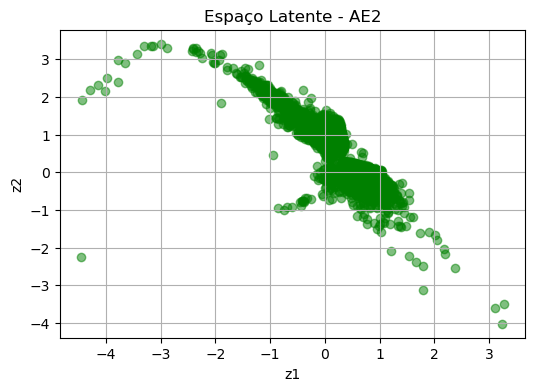

In [ ]:

autoencoder2.eval()
X_test_rec2 = []
latents2 = []

with torch.no_grad():
    for batch in test_loader:
        x_batch = batch[0].to(device)
        x_rec, z = autoencoder2(x_batch)
        X_test_rec2.append(x_rec.cpu().numpy())
        latents2.append(z.cpu().numpy())

X_test_rec2 = np.concatenate(X_test_rec2, axis=0)
latents2 = np.concatenate(latents2, axis=0)

mse_ae2 = mean_squared_error(X_test, X_test_rec2)
mae_ae2 = mean_absolute_error(X_test, X_test_rec2)

print(f"Autoencoder2 - Test MSE: {mse_ae2:.6f}, MAE: {mae_ae2:.6f}")

plt.figure(figsize=(6,4))
plt.scatter(latents2[:,0], latents2[:,1], c='green', alpha=0.5)
plt.title("Espaço Latente - AE2")
plt.xlabel("z1")
plt.ylabel("z2")
plt.grid(True)
plt.show()

### Erro absoluto está beirando 0.2268, erro quadrático em 0.16
### Espaço latente com uma distrubuição mais espalhada, provavelmente capturando mais variações de dados

### Salvando o segundo modelo 

In [ ]:
torch.save(autoencoder2.state_dict(), "autoencoder2.pth")
print("Autoencoder2 salvo!")

Autoencoder2 salvo!


### Definindo a estrutura do MOE
### Desligando os gradientes para não atualizarem eles no treinamento do MOE

In [ ]:

autoencoder1_moe = Autoencoder1().to(device)
autoencoder1_moe.load_state_dict(torch.load("autoencoder1.pth"))
autoencoder1_moe.eval()
for param in autoencoder1_moe.parameters():
    param.requires_grad = False

autoencoder2_moe = Autoencoder2().to(device)
autoencoder2_moe.load_state_dict(torch.load("autoencoder2.pth"))
autoencoder2_moe.eval()
for param in autoencoder2_moe.parameters():
    param.requires_grad = False

class MoE(nn.Module):
    def __init__(self, input_dim=8, latent_dim=2, combined_dim=4, bottleneck_dim=2, output_dim=8):
        super(MoE, self).__init__()
        
        # Combiner (mistura dos embeddings) - usado para produzir o bottleneck
        self.combiner = nn.Sequential(
            nn.Linear(combined_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, bottleneck_dim)
        )
        
        # Decoder (reconstruir entrada a partir do bottleneck)
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, output_dim)
        )
        
        # Camada de gating para gerar os pesos (logits) a partir do embedding concatenado
        # Temos 2 experts (AE1 e AE2)
        self.gate_layer = nn.Linear(combined_dim, 2)  
    
    def forward(self, x):
        # Extrair embeddings (congelados) dos dois AEs
        with torch.no_grad():
            _, z1 = autoencoder1_moe(x)
            _, z2 = autoencoder2_moe(x)
        
        # Concatena z1 e z2 => (batch, 4)
        z_combined = torch.cat([z1, z2], dim=1)
        
        # Geração dos logits para os experts
        gate_logits = self.gate_layer(z_combined)
        # Aplicar softmax para normalizar e obter os pesos (proporções) para cada expert
        gating_weights = torch.softmax(gate_logits, dim=1)  # Dimensão: (batch, 2)
        
        # Combinar embeddings
        z_moe = self.combiner(z_combined)  # (batch, bottleneck_dim)
        x_rec = self.decoder(z_moe)
        
        # Retorna a reconstrução, o bottleneck e os pesos da gating network
        return x_rec, z_moe, gating_weights

moe_model = MoE().to(device)

### Treinando o MOE

In [ ]:

num_epochs_moe = 100
lr_moe = 1e-3
criterion_moe = nn.MSELoss()
optimizer_moe = optim.Adam(moe_model.parameters(), lr=lr_moe)

train_losses_moe = []

for epoch in range(num_epochs_moe):
    moe_model.train()
    epoch_loss = 0
    for batch in train_loader:
        x_batch = batch[0].to(device)
        optimizer_moe.zero_grad()
        
        x_rec, _, _ = moe_model(x_batch)
        
        loss = criterion_moe(x_rec, x_batch)
        loss.backward()
        optimizer_moe.step()
        epoch_loss += loss.item() * x_batch.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    train_losses_moe.append(epoch_loss)
    
    if (epoch+1) % 20 == 0:
        print(f"[MoE] Epoch {epoch+1}/{num_epochs_moe}, Loss: {epoch_loss:.6f}")

[MoE] Epoch 20/100, Loss: 0.154353
[MoE] Epoch 40/100, Loss: 0.134430
[MoE] Epoch 60/100, Loss: 0.153839
[MoE] Epoch 80/100, Loss: 0.122488
[MoE] Epoch 100/100, Loss: 0.123221


### Avaliando as métricas do MOE

MoE - Test MSE: 0.122093, MAE: 0.226649


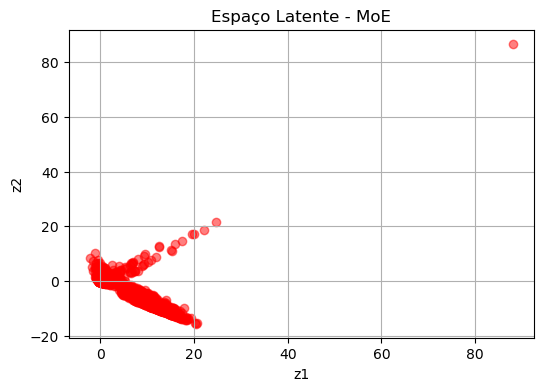

Média dos pesos da gating network para cada expert: [0.60426927 0.39572996]


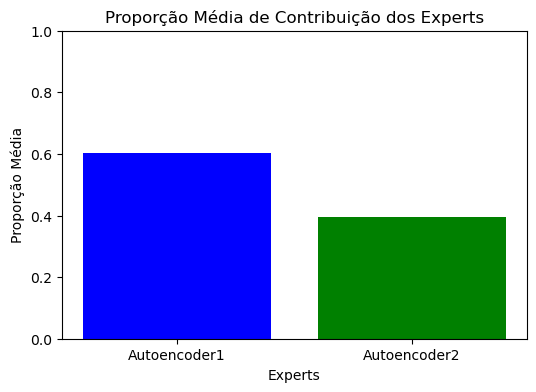

In [ ]:

moe_model.eval()
X_test_rec_moe = []
latents_moe = []
all_gating_weights = []

with torch.no_grad():
    for batch in test_loader:
        x_batch = batch[0].to(device)
        
        # Agora coletamos também os pesos de gating
        x_rec, z_moe, gating_weights = moe_model(x_batch)
        
        X_test_rec_moe.append(x_rec.cpu().numpy())
        latents_moe.append(z_moe.cpu().numpy())
        all_gating_weights.append(gating_weights.cpu().numpy())

# Concatenar os resultados de todo o conjunto de teste
X_test_rec_moe = np.concatenate(X_test_rec_moe, axis=0)
latents_moe = np.concatenate(latents_moe, axis=0)
all_gating_weights = np.concatenate(all_gating_weights, axis=0)  # (num_samples, 2)

# Cálculo das métricas de reconstrução
mse_moe = mean_squared_error(X_test, X_test_rec_moe)
mae_moe = mean_absolute_error(X_test, X_test_rec_moe)

print(f"MoE - Test MSE: {mse_moe:.6f}, MAE: {mae_moe:.6f}")

# Plot do espaço latente do MoE
plt.figure(figsize=(6,4))
plt.scatter(latents_moe[:,0], latents_moe[:,1], c='red', alpha=0.5)
plt.title("Espaço Latente - MoE")
plt.xlabel("z1")
plt.ylabel("z2")
plt.grid(True)
plt.show()

# Cálculo da média dos pesos de gating (proporção) para cada expert
avg_weights = np.mean(all_gating_weights, axis=0)
print("Média dos pesos da gating network para cada expert:", avg_weights)

# Plot de barras mostrando a proporção média de cada expert
experts_labels = ["Autoencoder1", "Autoencoder2"]
plt.figure(figsize=(6,4))
plt.bar(experts_labels, avg_weights, color=['blue', 'green'])
plt.title("Proporção Média de Contribuição dos Experts")
plt.xlabel("Experts")
plt.ylabel("Proporção Média")
plt.ylim(0, 1)
plt.show()

O espaço latente resultante ainda mostra duas distribuições principais:
Uma faixa densa de pontos perto de (0 < z1 < 20, -20 < z2 < 20), que provavelmente vem do Autoencoder2 (AE2), pois ele gerou uma distribuição mais contínua.
Uma ramificação diagonal ascendente, que pode indicar um padrão aprendido pelo AE1.
Um outlier extremo em (z1 ≈ 85, z2 ≈ 85), possivelmente causado pela contribuição dominante do AE1, que tinha problemas com outliers.

A Gating Network atribuiu pesos médios de 60,4% para o Autoencoder1 e 39,5% para o Autoencoder2.
Isso significa que o Autoencoder1 teve mais influência na codificação final do espaço latente.
Como o AE1 tinha um problema de concentração de pontos e um outlier extremo, isso pode explicar o fato do MoE ainda apresentar um outlier isolado no canto superior direito do gráfico.



         Modelo       MSE       MAE
0  Autoencoder1  0.173474  0.224720
1  Autoencoder2  0.162574  0.226887
2           MoE  0.122093  0.226649


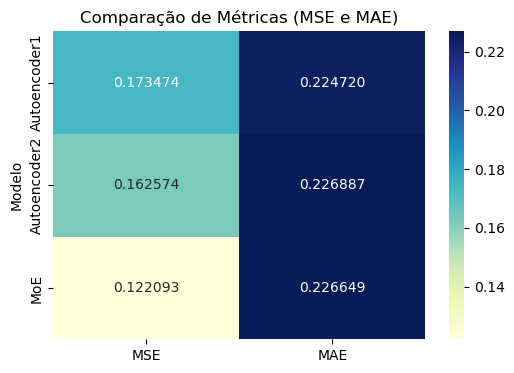

In [ ]:

data = {
    "Modelo": ["Autoencoder1", "Autoencoder2", "MoE"],
    "MSE": [mse_ae1, mse_ae2, mse_moe],
    "MAE": [mae_ae1, mae_ae2, mae_moe]
}

df_metrics = pd.DataFrame(data)
print(df_metrics)

plt.figure(figsize=(6,4))
sns.heatmap(df_metrics.set_index("Modelo"), annot=True, fmt=".6f", cmap="YlGnBu")
plt.title("Comparação de Métricas (MSE e MAE)")
plt.show()

O MoE apresenta o menor MSE, indicando que ele conseguiu fazer uma reconstrução mais precisa do que os autoencoders individuais. Isso mostra que a combinação dos especialistas ajudou a reduzir a perda no espaço latente.

 O MoE tem um MAE ligeiramente menor que o AE2, mas quase idêntico. Isso sugere que, apesar de ter melhorado no MSE, a redução dos erros absolutos não foi tão significativa.



O MoE conseguiu melhorar a reconstrução dos dados, reduzindo significativamente o MSE em comparação aos autoencoders individuais.
O MAE não teve uma grande melhora, indicando que o MoE pode estar reduzindo grandes erros (impactando o MSE) sem alterar tanto os erros médios.
O AE2 teve um desempenho melhor que o AE1 no MSE, o que pode explicar porque o MoE deu um peso menor ao AE2 na gating network (~39,5% vs. 60,4%).

O MoE é o melhor modelo em termos de MSE, mostrando que a combinação dos autoencoders ajudou a melhorar a representação dos dados.

O MAE não teve uma melhora tão grande, o que pode indicar que ainda existem erros menores constantes na reconstrução.

O MoE conseguiu fundir os dois autoencoders, mas a distribuição desigual dos pesos (60% vs 40%) favoreceu mais um especialista.
O espaço latente resultante tem melhor estruturação, mas ainda sofre com outliers, indicando que o AE1 teve uma influência excessiva na decisão final.
A separação em duas regiões sugere que os dois especialistas capturaram diferentes padrões nos dados, e o MoE está combinando esses padrões de forma diferenciada.

Para melhorar o resultado, algumas estratégias podem ser testadas:

Regularizar a contribuição dos especialistas: Forçar pesos mais equilibrados pode evitar que um AE domine o aprendizado.
Ajustar a arquitetura do AE1: Pode valer a pena revisar a estrutura do AE1 para que ele não gere outliers tão distantes.
Explorar a remoção do outlier: Se for uma anomalia no dataset, talvez seja útil identificá-lo e tratar esse ponto antes do treinamento.
Adicionar mais especialistas, mais épocas...